<a href="https://colab.research.google.com/github/t-nakatani/signate_stu22/blob/exp/signate_stu_v27.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

v26との比較で"allenai/scibert_scivocab_uncased"を用いる．  
suede labelingを導入



In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

from google.colab import drive
drive.mount('/content/drive')
ROOT = "/content/drive/MyDrive/Colab Notebooks/signate/"

#学習用データと評価用データの読み込み
train = pd.read_csv(os.path.join(ROOT, "train_cleaned.csv")).drop_duplicates(subset='description')
test = pd.read_csv(os.path.join(ROOT, "test_cleaned.csv"))

jobdic = dict(zip([1, 2, 3, 4], ['DataScientist', 'ML Engineer', 'Software Engineer', 'Consultant']))

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
!pip install -q transformers==3

In [4]:
import numpy as np
import transformers
import torch
from torch.utils.data import Dataset, DataLoader
# from transformers import RobertaTokenizer, RobertaModel
# from transformers import BertModel, AutoTokenizer 

from transformers import AutoTokenizer, AutoModelForSequenceClassification, AutoConfig
# from transformers import BertTokenizer, BertModel
from torch import optim
from torch import cuda
import time
from matplotlib import pyplot as plt
from tqdm import tqdm
from sklearn.metrics import f1_score

In [5]:
# seeds
SEED = 2022
def seed_everything(seed):
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)

seed_everything(SEED)

if torch.cuda.is_available():
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    current_device = torch.cuda.current_device()
    print("Device:", torch.cuda.get_device_name(current_device))

Device: Tesla P100-PCIE-16GB


In [6]:
# Datasetの定義
class CreateDataset(Dataset):
  def __init__(self, X, y, tokenizer, max_len):
    self.X = X
    self.y = y
    self.tokenizer = tokenizer
    self.max_len = max_len

  def __len__(self):  # len(Dataset)で返す値を指定
    return len(self.X)

  def __getitem__(self, index):  # Dataset[index]で返す値を指定
    text = self.X[index]
    inputs = self.tokenizer.encode_plus(
      text,
      add_special_tokens=True,
      max_length=self.max_len,
      pad_to_max_length=True,
      truncation=True
    )
    ids = inputs['input_ids']
    mask = inputs['attention_mask']
    labels = self.y[index]

    return {
      'ids': torch.LongTensor(ids),
      'mask': torch.LongTensor(mask),
      'labels': torch.Tensor(labels)
    }

1. from_pretrainedの文字列でconfig.from_pretrainedを呼び出し
2. config.from_pretrainedの結果をconfigにセット

In [7]:
# BERT分類モデルの定義
class BERTClass(torch.nn.Module):
  def __init__(self, drop_rate, otuput_size):
    super().__init__()
    self.config = AutoConfig.from_pretrained("allenai/scibert_scivocab_uncased", num_labels=4)
    self.bert = AutoModelForSequenceClassification.from_pretrained("allenai/scibert_scivocab_uncased", config=self.config)

  def forward(self, ids, mask):
    out = self.bert(ids, attention_mask=mask)
    return out[0]

In [8]:
def calculate_loss_and_f1_score(model, criterion, loader, device, epoch, max_epoch):
  """ 損失・正解率を計算"""
  model.eval()
  loss = 0.0
  total = 0
  correct = 0
  all_labels = []
  all_preds = []

  with torch.no_grad():
    with tqdm(loader) as pbar:
      pbar.set_description('valid')
      for i, data in enumerate(pbar):
        ids = data['ids'].to(device)
        mask = data['mask'].to(device)
        labels = data['labels'].to(device)


        outputs = model(ids, mask)
        loss += criterion(outputs, labels).item()

        preds = torch.argmax(outputs, dim=-1).cpu().numpy() # バッチサイズの長さの予測ラベル配列
        labels = torch.argmax(labels, dim=-1).cpu().numpy()  # バッチサイズの長さの正解ラベル配列
        all_labels += labels.tolist()
        all_preds += preds.tolist()
        total += len(labels)
        correct += (preds == labels).sum().item()
        pbar.set_postfix(loss=loss/(i+1), f1=f1_score(all_labels, all_preds, average="macro"))

  return loss / len(loader), f1_score(all_labels, all_preds, average="macro")

In [9]:
def train_val(train_loader, val_loader, model_path):
  device = 'cuda' if cuda.is_available() else 'cpu'
  model = BERTClass(DROP_RATE, OUTPUT_SIZE).to(device)
  criterion = torch.nn.CrossEntropyLoss()
  optimizer = torch.optim.AdamW(params=model.parameters(), lr=LEARNING_RATE)
  
  log_valid = []
  best_acc = 0
  all_labels = []
  all_preds = []

  # train
  for epoch in range(NUM_EPOCHS):
    print('\nepoch:', epoch+1)
    loss_train = correct = total = 0
    model.train()
    with tqdm(train_loader) as pbar:
      pbar.set_description('train')
      for i, data in enumerate(pbar):
        ids = data['ids'].to(device)
        mask = data['mask'].to(device)
        labels = data['labels'].to(device)

        optimizer.zero_grad()

        outputs = model(ids, mask)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        loss_train += loss.item()
        preds = torch.argmax(outputs, dim=-1).cpu().numpy()
        labels = torch.argmax(labels, dim=-1).cpu().numpy()

        all_labels += labels.tolist()
        all_preds += preds.tolist()

        total += len(labels)
        correct += (preds == labels).sum().item()
        pbar.set_postfix(loss=loss_train/(i+1), f1=f1_score(all_labels, all_preds, average="macro"))

    loss_valid, f1_valid = calculate_loss_and_f1_score(model, criterion, val_loader, device, epoch, NUM_EPOCHS)
    log_valid.append([loss_valid, f1_valid])
    if best_acc < f1_valid:
      best_acc = f1_valid
      
      torch.save(model, os.path.join(ROOT, model_path))
      print('==== model saved ====')

  return log_valid

In [10]:
DROP_RATE = 0.1
OUTPUT_SIZE = 4
BATCH_SIZE = 16
NUM_EPOCHS = 10
LEARNING_RATE = 2e-5
N_CV = 5
VERSION = 'v27'

In [19]:
import sklearn.metrics
def train_val_predict(
        df_train,       # 学習用のデータ
        text_column,    # 対象のカラム名
        target_column,  # 目的変数のカラム名
        df_valid=None,  # 検証用データ
        df_val_test=None,       # 予測用データ
        model_file_prefix="",  # 保存時のファイル名識別子
        epochs=NUM_EPOCHS,
        batch_size=BATCH_SIZE,
        from_pretrained = False
    ):
  
    # model
    model_path = "{}_{}.pth".format(model_file_prefix, VERSION)
    if from_pretrained:
      model = from_pretrained
      print('=== loading model from local ===')
    else:
      model = BERTClass(DROP_RATE, OUTPUT_SIZE)
      print('=== loading model from remote ===')
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.AdamW(params=model.parameters(), lr=LEARNING_RATE)
    device = 'cuda' if cuda.is_available() else 'cpu'

    # dataset
    df_val_test[target_column].fillna(0)

    max_len = 400
    tokenizer = AutoTokenizer.from_pretrained("allenai/scibert_scivocab_uncased")
    dataset_train = CreateDataset(df_train[text_column].values, pd.get_dummies(df_train[target_column]).values, tokenizer, max_len)
    dataset_val = CreateDataset(df_valid[text_column].values, pd.get_dummies(df_valid[target_column]).values, tokenizer, max_len)
    dataset_test = CreateDataset(df_val_test[text_column].values, pd.get_dummies(df_val_test[target_column]).values, tokenizer, max_len)

    dataloader_train = DataLoader(dataset_train, batch_size=BATCH_SIZE, shuffle=True)
    dataloader_valid = DataLoader(dataset_val, batch_size=BATCH_SIZE, shuffle=True)
    dataloader_test = DataLoader(dataset_test, batch_size=BATCH_SIZE, shuffle=False)

    # train
    print('\n================  start train  ================')
    metric = train_val(dataloader_train, dataloader_valid, model_path)
    print('================  end train  ================\n')

    # predict
    model = torch.load(os.path.join(ROOT, model_path))
    model.eval()
    pred_y_list = []
    emb_list = []
    with torch.no_grad():
      with tqdm(dataloader_test) as pbar:
        pbar.set_description('test')
        for data in pbar:
          ids = data['ids'].to(device)
          mask = data['mask'].to(device)
          labels = data['labels'].to(device)

          output = model.forward(ids, mask)
          pred = torch.argmax(output, dim=-1).cpu().numpy()

          pred_y_list.extend(pred)
          emb_list.extend(output.cpu().numpy())
    return metric, pred_y_list, emb_list

In [11]:
import sklearn.model_selection

text_column, target_column, n_splits = ('description', 'jobflag', N_CV)

df = pd.concat([train, test], ignore_index=True, sort=False)
df_train = df[df[target_column].notnull()]
df_test = df[df[target_column].isnull()]

df_train_idx = df_train.index

# store result
df_pred = pd.DataFrame(df.index, columns=["index"]).set_index("index")
df_emb = pd.DataFrame(df.index, columns=["index"]).set_index("index")
df_emb_pred = None
metric_list = []
all_emb = []

# cross validation
kf = sklearn.model_selection.StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=SEED)
for i, (train_idx, test_idx) in enumerate(kf.split(df_train, df_train[target_column])):
  df_train_sub = df_train.iloc[train_idx]
  df_test_sub = df_train.iloc[test_idx]

  df_val_test = pd.concat([df_test_sub, df_test], ignore_index=True, sort=False)

  model_file_prefix = "cv_{}".format(i)

  # train
  metric, pred_y_list, emb_list = train_val_predict(
      df_train=df_train_sub, 
      text_column=text_column,
      target_column=target_column, 
      df_valid=df_test_sub,
      df_val_test=df_val_test,
      model_file_prefix=model_file_prefix,
  )
  metric_list.append(metric)
  all_emb.append(emb_list)
  # break

Downloading:   0%|          | 0.00/385 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/442M [00:00<?, ?B/s]

- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Downloading:   0%|          | 0.00/228k [00:00<?, ?B/s]


================  start train  ================


- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



epoch: 1


valid: 100%|██████████| 19/19 [00:04<00:00,  4.31it/s, f1=0.531, loss=0.815]


==== model saved ====

epoch: 2


valid: 100%|██████████| 19/19 [00:04<00:00,  4.33it/s, f1=0.591, loss=0.745]


==== model saved ====

epoch: 3


valid: 100%|██████████| 19/19 [00:04<00:00,  4.31it/s, f1=0.61, loss=0.705]


==== model saved ====

epoch: 4


valid: 100%|██████████| 19/19 [00:04<00:00,  4.28it/s, f1=0.683, loss=0.665]


==== model saved ====

epoch: 5


valid: 100%|██████████| 19/19 [00:04<00:00,  4.30it/s, f1=0.695, loss=0.717]


==== model saved ====

epoch: 6


valid: 100%|██████████| 19/19 [00:04<00:00,  4.25it/s, f1=0.599, loss=0.988]



epoch: 7


valid: 100%|██████████| 19/19 [00:04<00:00,  4.32it/s, f1=0.629, loss=0.932]



epoch: 8


valid: 100%|██████████| 19/19 [00:04<00:00,  4.32it/s, f1=0.636, loss=0.988]



epoch: 9


valid: 100%|██████████| 19/19 [00:04<00:00,  4.32it/s, f1=0.631, loss=1.09]



epoch: 10


valid: 100%|██████████| 19/19 [00:04<00:00,  4.33it/s, f1=0.653, loss=1.24]


================  end train  ================



test: 100%|██████████| 114/114 [00:26<00:00,  4.36it/s]
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



================  start train  ================


- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



epoch: 1


valid: 100%|██████████| 19/19 [00:04<00:00,  4.33it/s, f1=0.548, loss=0.733]


==== model saved ====

epoch: 2


valid: 100%|██████████| 19/19 [00:04<00:00,  4.32it/s, f1=0.621, loss=0.696]


==== model saved ====

epoch: 3


valid: 100%|██████████| 19/19 [00:04<00:00,  4.32it/s, f1=0.689, loss=0.683]


==== model saved ====

epoch: 4


valid: 100%|██████████| 19/19 [00:04<00:00,  4.29it/s, f1=0.724, loss=0.766]


==== model saved ====

epoch: 5


valid: 100%|██████████| 19/19 [00:04<00:00,  4.33it/s, f1=0.703, loss=0.778]



epoch: 6


valid: 100%|██████████| 19/19 [00:04<00:00,  4.32it/s, f1=0.686, loss=1.02]



epoch: 7


valid: 100%|██████████| 19/19 [00:04<00:00,  4.33it/s, f1=0.655, loss=1.02]



epoch: 8


valid: 100%|██████████| 19/19 [00:04<00:00,  4.33it/s, f1=0.585, loss=1.17]



epoch: 9


valid: 100%|██████████| 19/19 [00:04<00:00,  4.34it/s, f1=0.696, loss=1.12]



epoch: 10


valid: 100%|██████████| 19/19 [00:04<00:00,  4.32it/s, f1=0.65, loss=1.26]


================  end train  ================



test: 100%|██████████| 114/114 [00:26<00:00,  4.36it/s]
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



================  start train  ================


- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



epoch: 1


valid: 100%|██████████| 19/19 [00:04<00:00,  4.34it/s, f1=0.543, loss=0.78]


==== model saved ====

epoch: 2


valid: 100%|██████████| 19/19 [00:04<00:00,  4.19it/s, f1=0.646, loss=0.653]


==== model saved ====

epoch: 3


valid: 100%|██████████| 19/19 [00:04<00:00,  4.35it/s, f1=0.692, loss=0.651]


==== model saved ====

epoch: 4


valid: 100%|██████████| 19/19 [00:04<00:00,  4.35it/s, f1=0.682, loss=0.7]



epoch: 5


valid: 100%|██████████| 19/19 [00:04<00:00,  4.36it/s, f1=0.661, loss=0.845]



epoch: 6


valid: 100%|██████████| 19/19 [00:04<00:00,  4.33it/s, f1=0.702, loss=0.769]


==== model saved ====

epoch: 7


valid: 100%|██████████| 19/19 [00:04<00:00,  4.35it/s, f1=0.687, loss=0.935]



epoch: 8


valid: 100%|██████████| 19/19 [00:04<00:00,  4.33it/s, f1=0.681, loss=1.03]



epoch: 9


valid: 100%|██████████| 19/19 [00:04<00:00,  4.35it/s, f1=0.666, loss=1]



epoch: 10


valid: 100%|██████████| 19/19 [00:04<00:00,  4.35it/s, f1=0.688, loss=1.03]


================  end train  ================



test: 100%|██████████| 114/114 [00:25<00:00,  4.40it/s]
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



================  start train  ================


- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



epoch: 1


valid: 100%|██████████| 19/19 [00:04<00:00,  4.37it/s, f1=0.519, loss=0.817]


==== model saved ====

epoch: 2


valid: 100%|██████████| 19/19 [00:04<00:00,  4.36it/s, f1=0.632, loss=0.711]


==== model saved ====

epoch: 3


valid: 100%|██████████| 19/19 [00:04<00:00,  4.37it/s, f1=0.64, loss=0.664]


==== model saved ====

epoch: 4


valid: 100%|██████████| 19/19 [00:04<00:00,  4.37it/s, f1=0.659, loss=0.701]


==== model saved ====

epoch: 5


valid: 100%|██████████| 19/19 [00:04<00:00,  4.35it/s, f1=0.63, loss=0.837]



epoch: 6


valid: 100%|██████████| 19/19 [00:04<00:00,  4.37it/s, f1=0.667, loss=0.914]


==== model saved ====

epoch: 7


valid: 100%|██████████| 19/19 [00:04<00:00,  4.36it/s, f1=0.671, loss=0.855]


==== model saved ====

epoch: 8


valid: 100%|██████████| 19/19 [00:04<00:00,  4.36it/s, f1=0.68, loss=1.02]


==== model saved ====

epoch: 9


valid: 100%|██████████| 19/19 [00:04<00:00,  4.36it/s, f1=0.669, loss=1.04]



epoch: 10


valid: 100%|██████████| 19/19 [00:04<00:00,  4.36it/s, f1=0.683, loss=1.08]


==== model saved ====
================  end train  ================



test: 100%|██████████| 114/114 [00:26<00:00,  4.36it/s]
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



================  start train  ================


- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



epoch: 1


valid: 100%|██████████| 19/19 [00:04<00:00,  4.35it/s, f1=0.534, loss=0.77]


==== model saved ====

epoch: 2


valid: 100%|██████████| 19/19 [00:04<00:00,  4.35it/s, f1=0.655, loss=0.708]


==== model saved ====

epoch: 3


valid: 100%|██████████| 19/19 [00:04<00:00,  4.35it/s, f1=0.662, loss=0.733]


==== model saved ====

epoch: 4


valid: 100%|██████████| 19/19 [00:04<00:00,  4.34it/s, f1=0.676, loss=0.752]


==== model saved ====

epoch: 5


valid: 100%|██████████| 19/19 [00:04<00:00,  4.34it/s, f1=0.681, loss=0.943]


==== model saved ====

epoch: 6


valid: 100%|██████████| 19/19 [00:04<00:00,  4.34it/s, f1=0.691, loss=1.08]


==== model saved ====

epoch: 7


valid: 100%|██████████| 19/19 [00:04<00:00,  4.35it/s, f1=0.656, loss=1.08]



epoch: 8


valid: 100%|██████████| 19/19 [00:04<00:00,  4.33it/s, f1=0.673, loss=1.17]



epoch: 9


valid: 100%|██████████| 19/19 [00:04<00:00,  4.33it/s, f1=0.677, loss=1.09]



epoch: 10


valid: 100%|██████████| 19/19 [00:04<00:00,  4.33it/s, f1=0.661, loss=1.24]


================  end train  ================



test: 100%|██████████| 114/114 [00:28<00:00,  4.00it/s]


In [12]:
all_emb_ = np.array([np.array(emb)[-len(df_test):] for emb in all_emb])

In [13]:
all_emb_ = np.array([np.array(emb)[-len(df_test):] for emb in all_emb])

mean_df = pd.DataFrame([[np.mean(arr_val) for arr_val in arr_vec] for arr_vec in np.moveaxis(all_emb_, 0, 2)])
preds = [np.argmax(arr)+1 for arr in mean_df.to_numpy()]
df_submit = pd.DataFrame([df_test.id.to_list(), preds]).T
df_submit.to_csv(os.path.join(ROOT, f'{VERSION}_ensemble.csv'), index=None, header=None)

In [14]:
f1_list = []
for item in metric_list:
  f1_list.append((np.max([acc for loss, acc in item])))
print(np.mean(f1_list))

0.6990081156516446


In [13]:
df_v10 = pd.read_csv(os.path.join(ROOT, 'v10_ensemble.csv'), header=None)
df_v27 = pd.read_csv(os.path.join(ROOT, 'v27_ensemble.csv'), header=None)
concat = pd.concat([df_v27, df_v10])
df_dup = concat[concat.duplicated()]

In [14]:
dup_idx = df_dup[0].values - 1516
test_suede_labeled_ = test.iloc[dup_idx]
test_suede_labeled_['jobflag'] = df_dup[1]
test_suede_labeled = test_suede_labeled_.drop_duplicates(subset='description')

test_suede_labeled

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,id,description,jobflag
0,1516,Building decision making models proposing solu...,1
1,1517,Educate homeowners benefits solar energy virtu...,4
2,1518,Design develop document implement applications...,3
3,1519,Apply advanced technical expertise skills impl...,4
4,1520,Project manage deliver against roadmapCollabor...,3
...,...,...,...
1512,3028,Manages development interface requirements int...,3
1513,3029,Lead implementation statistical modeling capab...,1
1514,3030,Configure Zuora fulfill casesIdentify areas co...,3
1515,3031,Gather translate document stakeholder requirem...,4


In [15]:
test_remained_idx = concat.drop_duplicates(keep=False)[0].values - 1516
test_remained = test.iloc[test_remained_idx]
test_remained

,id,description
6,1522,Create validate stress test algorithms that em...
23,1539,Ensuring that algorithms generate accurate use...
55,1571,Contribute technical leadership project still ...
75,1591,Work with project manager product owner meet s...
77,1593,Facilitate collaborative design sessions shape...
...,...,...
1474,2990,Design automated workflow process forms notifi...
1480,2996,Build PowerPoint briefingsDraft meeting minute...
1484,3000,Support Product owner Product Manager Support ...
1489,3005,Decompose user requirements into logical funct...


In [17]:
DROP_RATE = 0.1
OUTPUT_SIZE = 4
BATCH_SIZE = 16
NUM_EPOCHS = 10
LEARNING_RATE = 2e-5
N_CV = 5
VERSION = 'v27'

text_column, target_column, n_splits = ('description', 'jobflag', N_CV)


In [20]:
import sklearn.model_selection

df = pd.concat([test_suede_labeled, test_remained], ignore_index=True, sort=False)
df_train = df[df[target_column].notnull()]
df_test = df[df[target_column].isnull()]

df_train_idx = test_suede_labeled.index

# store result
df_pred = pd.DataFrame(df.index, columns=["index"]).set_index("index")
df_emb = pd.DataFrame(df.index, columns=["index"]).set_index("index")
df_emb_pred = None
metric_list = []
all_emb = []

# cross validation
kf = sklearn.model_selection.StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=SEED)
for i, (train_idx, test_idx) in enumerate(kf.split(df_train, df_train[target_column])):
  df_train_sub = df_train.iloc[train_idx]
  df_test_sub = df_train.iloc[test_idx]

  df_val_test = pd.concat([df_test_sub, df_test], ignore_index=True, sort=False)

  model_file_prefix = "cv_{}".format(i)
  model_path = "{}_{}.pth".format(model_file_prefix, VERSION)
  pretrained_model = torch.load(os.path.join(ROOT, model_path))

  # train
  metric, pred_y_list, emb_list = train_val_predict(
      df_train=df_train_sub, 
      text_column=text_column,
      target_column=target_column, 
      df_valid=df_test_sub,
      df_val_test=df_val_test,
      model_file_prefix='second_' + model_file_prefix,
      from_pretrained = pretrained_model
  )
  metric_list.append(metric)
  all_emb.append(emb_list)
  # break

=== loading model from local ===

================  start train  ================


- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



epoch: 1


valid: 100%|██████████| 17/17 [00:03<00:00,  4.47it/s, f1=0.665, loss=0.369]


==== model saved ====

epoch: 2


valid: 100%|██████████| 17/17 [00:03<00:00,  4.45it/s, f1=0.812, loss=0.334]


==== model saved ====

epoch: 3


valid: 100%|██████████| 17/17 [00:03<00:00,  4.48it/s, f1=0.85, loss=0.32]


==== model saved ====

epoch: 4


valid: 100%|██████████| 17/17 [00:03<00:00,  4.46it/s, f1=0.845, loss=0.381]



epoch: 5


valid: 100%|██████████| 17/17 [00:03<00:00,  4.46it/s, f1=0.84, loss=0.451]



epoch: 6


valid: 100%|██████████| 17/17 [00:03<00:00,  4.47it/s, f1=0.854, loss=0.374]


==== model saved ====

epoch: 7


valid: 100%|██████████| 17/17 [00:03<00:00,  4.47it/s, f1=0.859, loss=0.314]


==== model saved ====

epoch: 8


valid: 100%|██████████| 17/17 [00:03<00:00,  4.47it/s, f1=0.856, loss=0.553]



epoch: 9


valid: 100%|██████████| 17/17 [00:03<00:00,  4.48it/s, f1=0.895, loss=0.293]


==== model saved ====

epoch: 10


valid: 100%|██████████| 17/17 [00:03<00:00,  4.47it/s, f1=0.901, loss=0.305]


==== model saved ====
================  end train  ================



test: 100%|██████████| 42/42 [00:09<00:00,  4.20it/s]


=== loading model from local ===

================  start train  ================


- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



epoch: 1


valid: 100%|██████████| 17/17 [00:03<00:00,  4.49it/s, f1=0.645, loss=0.395]


==== model saved ====

epoch: 2


valid: 100%|██████████| 17/17 [00:03<00:00,  4.49it/s, f1=0.88, loss=0.236]


==== model saved ====

epoch: 3


valid: 100%|██████████| 17/17 [00:03<00:00,  4.49it/s, f1=0.812, loss=0.354]



epoch: 4


valid: 100%|██████████| 17/17 [00:03<00:00,  4.43it/s, f1=0.916, loss=0.158]


==== model saved ====

epoch: 5


valid: 100%|██████████| 17/17 [00:03<00:00,  4.50it/s, f1=0.824, loss=0.243]



epoch: 6


valid: 100%|██████████| 17/17 [00:03<00:00,  4.49it/s, f1=0.812, loss=0.287]



epoch: 7


valid: 100%|██████████| 17/17 [00:03<00:00,  4.47it/s, f1=0.858, loss=0.182]



epoch: 8


valid: 100%|██████████| 17/17 [00:03<00:00,  4.49it/s, f1=0.901, loss=0.239]



epoch: 9


valid: 100%|██████████| 17/17 [00:03<00:00,  4.47it/s, f1=0.879, loss=0.162]



epoch: 10


valid: 100%|██████████| 17/17 [00:03<00:00,  4.47it/s, f1=0.847, loss=0.386]


================  end train  ================



test: 100%|██████████| 42/42 [00:09<00:00,  4.49it/s]


=== loading model from local ===

================  start train  ================


- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



epoch: 1


valid: 100%|██████████| 17/17 [00:03<00:00,  4.50it/s, f1=0.643, loss=0.5]


==== model saved ====

epoch: 2


valid: 100%|██████████| 17/17 [00:03<00:00,  4.50it/s, f1=0.86, loss=0.265]


==== model saved ====

epoch: 3


valid: 100%|██████████| 17/17 [00:03<00:00,  4.50it/s, f1=0.703, loss=0.618]



epoch: 4


valid: 100%|██████████| 17/17 [00:03<00:00,  4.49it/s, f1=0.818, loss=0.319]



epoch: 5


valid: 100%|██████████| 17/17 [00:03<00:00,  4.51it/s, f1=0.941, loss=0.25]


==== model saved ====

epoch: 6


valid: 100%|██████████| 17/17 [00:03<00:00,  4.50it/s, f1=0.876, loss=0.299]



epoch: 7


valid: 100%|██████████| 17/17 [00:03<00:00,  4.48it/s, f1=0.893, loss=0.268]



epoch: 8


valid: 100%|██████████| 17/17 [00:03<00:00,  4.51it/s, f1=0.893, loss=0.236]



epoch: 9


valid: 100%|██████████| 17/17 [00:03<00:00,  4.48it/s, f1=0.908, loss=0.303]



epoch: 10


valid: 100%|██████████| 17/17 [00:03<00:00,  4.49it/s, f1=0.919, loss=0.23]


================  end train  ================



test: 100%|██████████| 42/42 [00:09<00:00,  4.41it/s]


=== loading model from local ===

================  start train  ================


- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



epoch: 1


valid: 100%|██████████| 17/17 [00:03<00:00,  4.50it/s, f1=0.636, loss=0.474]


==== model saved ====

epoch: 2


valid: 100%|██████████| 17/17 [00:03<00:00,  4.50it/s, f1=0.784, loss=0.321]


==== model saved ====

epoch: 3


valid: 100%|██████████| 17/17 [00:03<00:00,  4.51it/s, f1=0.817, loss=0.22]


==== model saved ====

epoch: 4


valid: 100%|██████████| 17/17 [00:03<00:00,  4.51it/s, f1=0.869, loss=0.231]


==== model saved ====

epoch: 5


valid: 100%|██████████| 17/17 [00:03<00:00,  4.50it/s, f1=0.835, loss=0.251]



epoch: 6


valid: 100%|██████████| 17/17 [00:03<00:00,  4.49it/s, f1=0.84, loss=0.172]



epoch: 7


valid: 100%|██████████| 17/17 [00:03<00:00,  4.52it/s, f1=0.857, loss=0.238]



epoch: 8


valid: 100%|██████████| 17/17 [00:03<00:00,  4.48it/s, f1=0.855, loss=0.278]



epoch: 9


valid: 100%|██████████| 17/17 [00:03<00:00,  4.49it/s, f1=0.906, loss=0.281]


==== model saved ====

epoch: 10


valid: 100%|██████████| 17/17 [00:03<00:00,  4.49it/s, f1=0.84, loss=0.376]


================  end train  ================



test: 100%|██████████| 42/42 [00:09<00:00,  4.49it/s]


=== loading model from local ===

================  start train  ================


- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



epoch: 1


valid: 100%|██████████| 17/17 [00:03<00:00,  4.45it/s, f1=0.641, loss=0.469]


==== model saved ====

epoch: 2


valid: 100%|██████████| 17/17 [00:03<00:00,  4.43it/s, f1=0.785, loss=0.317]


==== model saved ====

epoch: 3


valid: 100%|██████████| 17/17 [00:03<00:00,  4.45it/s, f1=0.817, loss=0.355]


==== model saved ====

epoch: 4


valid: 100%|██████████| 17/17 [00:03<00:00,  4.46it/s, f1=0.874, loss=0.333]


==== model saved ====

epoch: 5


valid: 100%|██████████| 17/17 [00:03<00:00,  4.45it/s, f1=0.866, loss=0.298]



epoch: 6


valid: 100%|██████████| 17/17 [00:03<00:00,  4.32it/s, f1=0.784, loss=0.54]



epoch: 7


valid: 100%|██████████| 17/17 [00:03<00:00,  4.45it/s, f1=0.839, loss=0.484]



epoch: 8


valid: 100%|██████████| 17/17 [00:03<00:00,  4.46it/s, f1=0.842, loss=0.41]



epoch: 9


valid: 100%|██████████| 17/17 [00:03<00:00,  4.46it/s, f1=0.846, loss=0.399]



epoch: 10


valid: 100%|██████████| 17/17 [00:03<00:00,  4.46it/s, f1=0.843, loss=0.547]


================  end train  ================



test: 100%|██████████| 42/42 [00:09<00:00,  4.48it/s]


In [44]:
all_emb_ = np.array([np.array(emb)[-len(df_test):] for emb in all_emb])

mean_df = pd.DataFrame([[np.mean(arr_val) for arr_val in arr_vec] for arr_vec in np.moveaxis(all_emb_, 0, 2)])
preds = [np.argmax(arr)+1 for arr in mean_df.to_numpy()]
df_submit = pd.DataFrame([df_test.id.to_list(), preds]).T

df_final_submit = df_v10.copy()
for id, label in zip(df_submit[0].values, df_submit[1].values):
  idx = id - 1516
  df_final_submit.iloc[idx, 1] = label

df_final_submit.to_csv(os.path.join(ROOT, f'{VERSION}_suede_ensemble.csv'), index=None, header=None)

In [45]:
f1_list = []
for item in metric_list:
  f1_list.append((np.max([acc for loss, acc in item])))
print(np.mean(f1_list))

0.9075335742262343


In [23]:
df_test

,id,description,jobflag
1291,1522,Create validate stress test algorithms that em...,NaN
1292,1539,Ensuring that algorithms generate accurate use...,NaN
1293,1571,Contribute technical leadership project still ...,NaN
1294,1591,Work with project manager product owner meet s...,NaN
1295,1593,Facilitate collaborative design sessions shape...,NaN
...,...,...,...
1688,2990,Design automated workflow process forms notifi...,NaN
1689,2996,Build PowerPoint briefingsDraft meeting minute...,NaN
1690,3000,Support Product owner Product Manager Support ...,NaN
1691,3005,Decompose user requirements into logical funct...,NaN


In [40]:
check_changed = pd.concat([df_final_submit, df_v10]).drop_duplicates()

In [42]:
len(check_changed) - len(df_final_submit)

201

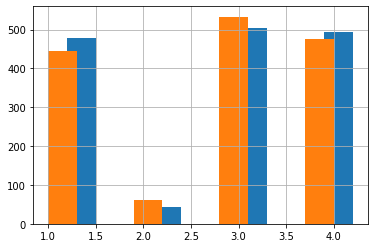

In [51]:
(df_v10[1]+0.2).hist() # blue
df_final_submit[1].hist() #orange

In [60]:
for id, dsc, label in zip(df_test['id'], df_test['description'], df_submit[1]):
  print(id, jobdic[label], ': ', dsc)
  # break

1522 ML Engineer :  Create validate stress test algorithms that employedShare ideas across team come with best algorithms approaches
1539 DataScientist :  Ensuring that algorithms generate accurate user recommendations Auto tagging images text speech conversions speech text conversion Running tests performing analysis interpreting test results
1571 ML Engineer :  Contribute technical leadership project still infancyDesign develop application automated processing systems
1591 DataScientist :  Work with project manager product owner meet specification needsCollaborating with management staff understand their needsCreate flowcharts user guides existing programsDocument tasks proceduresConducting research organization customers Developing plans implement solutionsKeeping abreast changes industry
1593 Consultant :  Facilitate collaborative design sessions shape target state vision identify transformation initiativesFocus outcome driven business recommendationsAct liaison between actuarial t

In [61]:
test[test['id'] == 1643]

,id,description
127,1643,Write documentation where appropriate
